### Image Classification Using Transfer Learning on Flowers Database

#### 1) Importing necessary pytorch modules

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Used for data loading
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.models import inception_v3
from torch.autograd import Variable
import torchvision

### Used for Neural Networks
import torch.nn as nn
from torch.optim import Adam, SGD, lr_scheduler

#### 2) Setting up seeds to reproduce results 

In [71]:
torch.backends.cudnn.deterministic = True
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#### 3) Defining functions to load data with necessary transforms 

In [72]:
def getDataLoaded(root, subdir, applyTransforms=True, batchSize=32, shuffle=True):
    """Reads data arranged as class labels from path obtained by joining root and subdir arguments"""
    if(applyTransforms):
        dataset = ImageFolder(root=root+'//'+subdir, 
                             transform=transforms.Compose([
                                 transforms.Scale(299),
                                 transforms.RandomCrop(299),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                             ]))
    else:
        dataset = ImageFolder(root=root+'//'+subdir, 
                              transform=transforms.Compose([
                                  transforms.Scale(299),
                                  transforms.RandomCrop(299),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                            ]))
    
    dataset_loader = DataLoader(dataset,batch_size=batchSize, shuffle=shuffle, num_workers=5)
    return dataset_loader

In [73]:
train_dataset = getDataLoaded(root = 'C:\\Users\\chait\\Desktop\\flowers_sample', subdir='train', 
                              applyTransforms=True, batchSize=16)
val_dataset = getDataLoaded(root = 'C:\\Users\\chait\\Desktop\\flowers_sample', subdir='valid', 
                              applyTransforms=False, batchSize=16, shuffle=False)
test_dataset = getDataLoaded(root = 'C:\\Users\\chait\\Desktop\\flowers_sample', subdir='test', 
                              applyTransforms=False, batchSize=16, shuffle=False)

C:\Users\chait\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [74]:
print("The length of train dataset is {}".format(len(train_dataset.dataset)))
print("The length of validation dataset is {}".format(len(val_dataset.dataset)))
print("The length of test dataset is {}".format(len(test_dataset.dataset)))

The length of train dataset is 427
The length of validation dataset is 43
The length of test dataset is 52


In [75]:
output_classes = 10

#### b) Visualizaing a batch in train dataset 

In [76]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


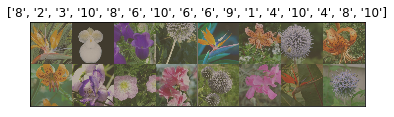

In [77]:
# Get a batch of training data
inputs, classes = next(iter(train_dataset))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_dataset.dataset.classes[x] for x in classes])

#### 4) Importing and modifying inception V3 model

In [78]:
incv3_model = inception_v3(pretrained=True)
incv3_model.parameters

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=

In [79]:
# Freeze training for all layers
for param in incv3_model.parameters():
    param.requires_grad = False


In [80]:
#Printing the final fully connected layer
print(incv3_model.fc)
incv3_model.fc.out_features = output_classes
print(incv3_model.fc)

Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=10, bias=True)


#### 5) Preparing the optimizer and loss functions

In [89]:
starting_lr = 0.002
#opt_fn = SGD(list(filter(lambda p: p.requires_grad, incv3_model.parameters())), lr=starting_lr, momentum=0.9)
opt_fn = SGD(incv3_model.parameters(), lr=starting_lr, momentum=0.9)
opt_lr_scheduler = lr_scheduler.StepLR(opt_fn, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

#### 6) Defining our train and test functions

In [82]:
def train(num_epochs):
    best_acc = 0.0;
    least_loss = 0.0; 
    for epoch in range(num_epochs):
        incv3_model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_dataset):
            opt_fn.zero_grad()
            train_outputs, aux = incv3_model(images)
            print("aux o/p are ", aux)
            print("Train o/p are ", train_outputs.data)
            #print("Labels data ", labels.data)
            loss1 = loss_fn(train_outputs, labels)
            loss2 = loss_fn(aux, labels)
            loss = loss1+loss2
            #loss = Variable(loss, requires_grad=True)
            loss.backward()
            opt_fn.step()
            train_loss += loss.cpu().data[0] * images.size(0)
            _, prediction = torch.max(train_outputs.data, 1)
            
            #print("The predictions for batch are ", prediction)
            train_acc += torch.sum(prediction == labels.data)
            #print("Cumulative Train acc for each batch in epoch is ", train_acc)
        
        opt_lr_scheduler.step()
        #print("The train acc for complete epoch is {} and train dataset length is {}".format(train_acc, len(train_dataset.dataset)))
        train_acc = train_acc.item()/len(train_dataset.dataset)
        train_loss = train_loss/len(train_dataset.dataset)
        losses.append(round(train_loss.item(),3))
        val_acc = evalModel(mode='validation')
        test_acc = evalModel(mode='test')
        train_acc_list.append(round(train_acc,3))
        val_acc_list.append(round(val_acc,3))
        test_acc_list.append(round(test_acc,3))
        if test_acc > best_acc:
            print("Saving best model on acc terms")
            saveBestModel(epoch)
            best_acc = test_acc
            least_loss = train_loss
        elif test_acc == best_acc:
            if(train_loss < least_loss):
                print("Saving best model on loss terms")
                saveBestModel(epoch)
                best_acc = test_acc
                least_loss = train_loss         
        print("Epoch {},  TrainLoss: {} , Train Accuracy: {}, Validation accuracy: {}, Test Accuracy: {}".format(epoch, round(train_loss.item(),3), round(train_acc,3), round(val_acc,3), round(test_acc,3)))


In [83]:
def evalModel(mode='test'):
    incv3_model.eval()
    acc = 0.0
    input_dataset = None
    if(mode == 'test'):
        input_dataset = test_dataset
    elif (mode == 'validation'):
        input_dataset = val_dataset
    
    for i, (images, labels) in enumerate(input_dataset):
        outputs = incv3_model(images)
        _,prediction = torch.max(outputs.data, 1)
        prediction = prediction.cpu().numpy()
        acc += torch.sum(prediction == labels.data)
    acc = acc.item()/len(input_dataset.dataset)
    return acc

In [84]:
def saveBestModel(epoch_num):
    torch.save(incv3_model.state_dict(), "models//TL_flowers10_best_incv3.model")
    print("Best Model Saved at epoch {}".format(epoch_num))


In [85]:
losses = [];
train_acc_list = []
val_acc_list = []
test_acc_list = []

train(12)

aux o/p are  tensor([[-0.7805, -1.7451, -1.3167,  ..., -1.3212,  1.7759,  0.1299],
        [-0.1696, -1.8769, -0.4536,  ...,  0.9870, -1.7407, -0.0587],
        [-1.7280, -1.1791, -0.4818,  ..., -2.2171, -1.6323,  1.9258],
        ...,
        [-0.1263,  0.8418, -1.5638,  ..., -1.6561, -0.8702, -1.7203],
        [-0.4178, -1.5735, -1.1790,  ..., -1.3204, -1.0147, -0.8605],
        [-0.3634,  0.6166, -2.1093,  ...,  1.8602, -1.3301,  2.6362]])
Train o/p are  tensor([[-1.5329, -1.1248, -1.4336,  ..., -1.5499,  1.3140,  0.5203],
        [-0.2359, -0.7654, -0.5897,  ...,  0.1425,  0.3789, -0.0757],
        [ 0.1873, -0.6042,  0.2086,  ..., -0.2543, -0.0425,  0.7186],
        ...,
        [-0.9838,  0.1705, -0.0260,  ..., -0.5958,  0.0777,  1.1985],
        [-0.6385, -0.8053, -1.3338,  ..., -1.4500, -1.0238, -0.2947],
        [-0.1873,  0.7368,  0.0718,  ...,  1.7600,  0.1563, -0.1861]])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

#### 7) Visualizing loss function

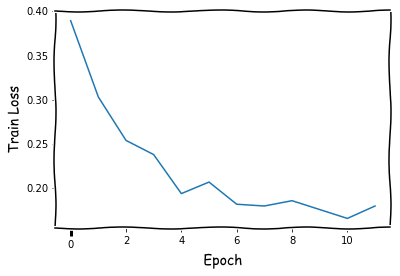

In [30]:
plt.xkcd();
plt.xlabel('Epoch');
plt.ylabel('Train Loss');
plt.plot(losses);
plt.show()

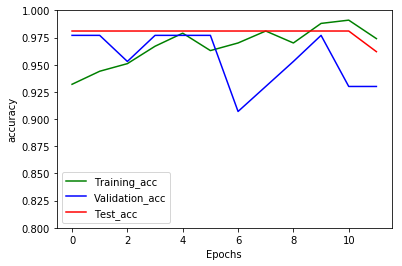

In [35]:
plt.plot(train_acc_list, color='green', label='Training_acc')
plt.plot(val_acc_list, color='blue', label='Validation_acc')
plt.plot(test_acc_list, color='red', label='Test_acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.ylim(0.8,1)
plt.legend()
plt.show()

#### 8) Visualizing the Test class using the best model

#### a) Loading the saved model

In [32]:
checkpoint = torch.load("models//TL_flowers10_best_vgg16.model")
print(type(checkpoint))
incv3_model.load_state_dict(checkpoint)
print(type(incv3_model))
#print(res18_model.fc.weight)

<class 'collections.OrderedDict'>
<class 'torchvision.models.vgg.VGG'>


#### b) Defining functions for viewing images

In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataset):
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(train_dataset.dataset.classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

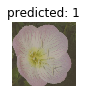

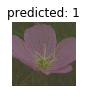

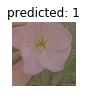

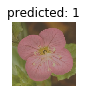

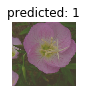

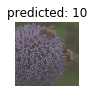

In [34]:
visualize_model(incv3_model)